In [5]:
# Importando as dependências
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Confirmando o uso de GPU no Colab
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU não encontrada!=')
print(f"GPU encontrada: {device_name}")


GPU encontrada: /device:GPU:0


In [6]:
# Instalando a biblioteca MTCNN
!pip install mtcnn

# Importando a MTCNN
from mtcnn import MTCNN

# Inicializando o detector
detector = MTCNN()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00


In [7]:
# Função para detectar faces em uma imagem
def detect_faces(image_path):
    # Carregando a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detectando faces
    results = detector.detect_faces(image_rgb)

    # Desenhando os retângulos ao redor das faces
    for result in results:
        x, y, width, height = result['box']
        cv2.rectangle(image, (x, y), (x+width, y+height), (0, 255, 0), 2)

    # Exibindo a imagem com as detecções
    cv2_imshow(image)

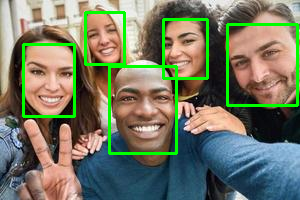

In [10]:
# Testando a detecção de faces
image_path = "/content/teste.jpg"
detect_faces(image_path)

In [11]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=9f543181686bb6a4fdca2764311803522e814c0a6881e44b887aa1dba6d0e385
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [12]:
from keras_facenet import FaceNet

# Inicializando o modelo FaceNet
embedder = FaceNet()

In [13]:
# Função para extrair embeddings
def get_embedding(image_path):
    # Carregando a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionando para o tamanho esperado pelo modelo
    image_resized = cv2.resize(image_rgb, (160, 160))
    # Gerando o embedding
    embedding = embedder.embeddings([image_resized])[0]
    return embedding

In [14]:
embedding = get_embedding("/content/teste.jpg")
print("Embedding gerado:", embedding)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Embedding gerado: [-0.01677845 -0.04517666 -0.03863833  0.03659856 -0.02752493 -0.00920542
  0.01982153 -0.09887592 -0.00205987 -0.03324044  0.02275104 -0.02199108
  0.00445425 -0.01312657  0.01926501  0.02091667  0.00414818  0.00364016
 -0.04863115  0.00638196 -0.03941683 -0.01718179  0.00688142  0.04127502
 -0.05391375  0.04367748 -0.01365825 -0.05300554 -0.05721591  0.00973414
 -0.00761554  0.06053802 -0.01926067  0.03730913 -0.11137723  0.06576243
 -0.00445181 -0.0271053  -0.03509831  0.04776925  0.01551461 -0.05827403
  0.01624587 -0.01518544  0.0455892   0.04849802  0.00639628  0.06338914
 -0.03209287  0.00797353  0.07256946  0.07677028 -0.0121017   0.05120583
 -0.06510557 -0.07593958  0.03960663 -0.02959299  0.0559967   0.01849398
  0.01495879  0.04032064  0.03918624 -0.07198353  0.02112989  0.08065175
 -0.020911   -0.03237878 -0.04671248  0.09959428  0.03976665  0.01821497
  0.07019276  0.02598123 -0.03496233  0.02023547 -0.05299316 -0.033645

In [15]:
# Criando um banco de dados de embeddings
database = {
    "Gabe": get_embedding("/content/gabe_top_png.png"),
    "Felipe": get_embedding("/content/marzani_adc_png.png"),
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [16]:
from numpy.linalg import norm

# Função para reconhecer a face
def recognize_face(detected_embedding, database, threshold=0.6):
    min_dist = float("inf")
    identity = "Desconhecido"

    for name, db_embedding in database.items():
        dist = norm(detected_embedding - db_embedding)
        print(f'Dist: {dist}')
        if dist < min_dist and dist < threshold:
            min_dist = dist
            identity = name

    return identity

In [17]:
# Testando o reconhecimento
detected_face = get_embedding("/content/marzani_adc_png.png")
identity = recognize_face(detected_face, database)
print(f"Identidade Reconhecida: {identity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Dist: 0.6540478467941284
Dist: 0.0
Identidade Reconhecida: Felipe


### Integrando Etapas

In [18]:
def detect_and_recognize(image_path, database, threshold=0.6):
    # Carregando a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detectando faces
    results = detector.detect_faces(image_rgb)

    for result in results:
        x, y, width, height = result['box']
        x, y = abs(x), abs(y)

        # Extraindo a face detectada
        face = image_rgb[y:y+height, x:x+width]
        face_resized = cv2.resize(face, (160, 160))

        # Gerando o embedding da face
        detected_embedding = embedder.embeddings([face_resized])[0]

        # Reconhecendo a face
        identity = recognize_face(detected_embedding, database, threshold)

        # Desenhando o resultado
        color = (0, 255, 0) if identity != "Desconhecido" else (0, 0, 255)
        cv2.rectangle(image, (x, y), (x+width, y+height), color, 2)
        cv2.putText(image, identity, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Exibindo a imagem com as detecções e identificações
    cv2_imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Dist: 1.458710789680481
Dist: 1.401537299156189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dist: 1.4697142839431763
Dist: 1.4610618352890015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Dist: 1.4466763734817505
Dist: 1.4710756540298462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dist: 1.4734325408935547
Dist: 1.4822237491607666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Dist: 1.3622069358825684
Dist: 1.338260293006897


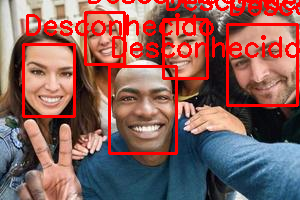

In [19]:
image_path = "/content/teste.jpg"
detect_and_recognize(image_path, database)

In [26]:
def detect_and_save_video(database, threshold=0.6, video_source="", output_path="output_video.avi"):
    # Captura de vídeo
    cap = cv2.VideoCapture(video_source)

    if not cap.isOpened():
        print("Erro ao abrir o vídeo.")
        return

    # Obtendo as propriedades do vídeo
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Inicializando o writer para salvar o vídeo
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Final do vídeo

        # Convertendo o frame para RGB (necessário para MTCNN)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detectando faces no frame
        results = detector.detect_faces(frame_rgb)

        for result in results:
            x, y, width, height = result['box']
            x, y = abs(x), abs(y)  # Corrigindo valores negativos

            # Extraindo a face detectada
            face = frame_rgb[y:y+height, x:x+width]
            face_resized = cv2.resize(face, (160, 160))

            # Gerando o embedding da face
            detected_embedding = embedder.embeddings([face_resized])[0]

            # Reconhecendo a face
            identity = recognize_face(detected_embedding, database, threshold)

            # Desenhando os resultados no frame
            color = (0, 255, 0) if identity != "Desconhecido" else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x+width, y+height), color, 2)
            cv2.putText(frame, identity, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Escrevendo o frame processado no arquivo de saída
        out.write(frame)

    # Liberando os recursos
    cap.release()
    out.release()
    print(f"Processamento concluído. Vídeo salvo em: {output_path}")


In [27]:
video_path = "/content/video.mp4"

# Processar e salvar o vídeo com detecções
detect_and_save_video(database, video_source=video_path, output_path="output_video.avi")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Dist: 1.370415210723877
Dist: 1.3846840858459473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dist: 1.3531339168548584
Dist: 1.3702274560928345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dist: 1.3201934099197388
Dist: 1.3375564813613892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dist: 1.367041826248169
Dist: 1.4084523916244507
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Dist: 1.3495256900787354
Dist: 1.367508888244629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Dist: 1.3637477159500122
Dist: 1.3976600170135498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Dist: 1.365248680114746
Dist: 1.3746750354766846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Dist: 1.3232709169387817
Dist: 1.3314372301101685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dist: 1.372792363166809
Dist: 1.3811880350112915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Dist: 1.382060170173645
Dist: 1.3895864486694336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Dist: 1.3732441663742065
Dist: 1.394327163696289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
D